In [24]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection._split import train_test_split
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import preprocessing
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, TimeDistributed, GRU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt


In [25]:
def prepare_sequences(sampl, window_size=100, shift=1): #prepare windows with a given size
    data_set = np.array([])
    labels = np.array([])
    temp_labels = sampl[:, 0]
    sampl = sampl[:, 1:]
    print(sampl.shape)
    for row_index in tqdm(range(0, sampl.shape[0] - window_size, shift)):
        if(row_index == 0):
            data_set = np.array([sampl[row_index : window_size]])
            labels = np.append(labels, temp_labels[row_index])
        else:
            if(temp_labels[row_index] == temp_labels[row_index + window_size]):
                window = sampl[row_index : row_index + window_size]
                data_set = np.append(data_set, [window], axis = 0)
                labels = np.append(labels, temp_labels[row_index])
    return data_set, labels

def load_data(file, nrows = None):
    path = "{}/{}".format("new_data_different_texts", file)
    data = pd.read_csv(path, sep=",", header = None, nrows = nrows) 
#     return np.array(data)
    return pd.DataFrame(data)

In [26]:
# files = os.listdir("{}".format("new_data_different_texts"))
files = os.listdir("{}".format("new_data_different_texts"))
frames = []
number_of_rows = 1500

for file in files: 
    print(file)
    data = load_data(file, number_of_rows)
    frames.append(data)
    
data = pd.concat(frames)
data = np.array(data)
data = data[:, :-1]

001001.txt
002001.txt
003001.txt
004001.txt
005001.txt
006001.txt
007001.txt
008001.txt
009001.txt
010001.txt
011001.txt
012001.txt
013001.txt
014001.txt
015001.txt
016001.txt
017001.txt
018001.txt
019001.txt
020001.txt


In [27]:
print(data)
keys = data[:, 1:3]
for row in range(keys.shape[0]):
    for column in range(keys.shape[1]):
        data[row, column + 1] = data[row, column + 1].lower().replace(" ", "")
        
print(data)

[[1 ' LMenu' ' Tab' ... 187 312 125]
 [1 ' Tab' ' LMenu' ... 172 1139 967]
 [1 ' LMenu' ' Tab' ... 124 218 94]
 ...
 [20 ' T' ' Space' ... 92 405 313]
 [20 ' Space' ' D1' ... 83 185 102]
 [20 ' D1' ' LControlKey' ... 975 10707 9732]]
[[1 'lmenu' 'tab' ... 187 312 125]
 [1 'tab' 'lmenu' ... 172 1139 967]
 [1 'lmenu' 'tab' ... 124 218 94]
 ...
 [20 't' 'space' ... 92 405 313]
 [20 'space' 'd1' ... 83 185 102]
 [20 'd1' 'lcontrolkey' ... 975 10707 9732]]


In [28]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((data[:,1], data[:,2]), axis=0).reshape(-1, 1))

first_column = enc.transform(data[:,1].reshape(-1, 1)).toarray()
second_column = enc.transform(data[:,2].reshape(-1, 1)).toarray()


In [29]:
# letters encoding - order: A1A2 B1B2 etc.
encoded_letters = [[]]

for i in range(0, first_column.shape[1]):
    if(i == 0):
      encoded_letters = np.column_stack((first_column[:, i], second_column[:, i]))
    else:
      encoded_letters = np.column_stack((encoded_letters, first_column[:, i], second_column[:, i]))


In [30]:
# normalization - z score
std_scaler = StandardScaler()
encoded_letters_scaled = std_scaler.fit_transform(encoded_letters) 
time_values_scaled = std_scaler.fit_transform(data[:, 3:])

In [31]:
prepared_data = np.column_stack((data[:, 0], encoded_letters_scaled, time_values_scaled))

In [32]:
def prepare_data(data, window_size, random_state = 1):
    data, labels = prepare_sequences(data, window_size = window_size, shift = int(window_size*0.4))
    samples = data
    samples = np.asarray(samples).astype('float32')
    labels = np.asarray(labels).astype('float32')
    (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, random_state=random_state)
#     (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, stratify=labels,random_state=1)

    #one hot encoding
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((trainLabels, testLabels), axis=0).reshape(-1, 1))
    print(trainLabels)
    trainLabels = enc.transform(trainLabels.reshape(-1, 1)).toarray()
    testLabels = enc.transform(testLabels.reshape(-1, 1)).toarray()
    print(trainLabels)
    
    return (trainSamples, testSamples, trainLabels, testLabels, samples, enc)

In [33]:
def print_history_params(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [34]:
# def train_model(model, optimizer, filter, neuron, kernel, dropout, window):
def train_model(model, optimizer):
    model.compile(loss='categorical_crossentropy', 
                  optimizer= optimizer,
                  metrics=['accuracy'])
    
    EPOCHS=100
    BATCH=64
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    ]
    
    history = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
            ,validation_data=(testSamples,testLabels)
            ,callbacks=my_callbacks)
    print_history_params(history);

In [35]:
def get_metrics(model):
    testResults = model.predict(testSamples)
    
    matrix = confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    report = classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    accuracy = accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    cohen_kappa = cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    return (matrix, report, accuracy, cohen_kappa)

def print_metrics(matrix, report, accuracy, cohen_kappa):
    print(matrix)
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Cohen's Kappa: {:.2f}".format(cohen_kappa))

In [36]:
from contextlib import redirect_stdout

def save_model(model, test):          
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    
    with open(f"{test}",'a') as f:
        with redirect_stdout(f):
            model.summary()
        
    os.chdir("../..")

In [37]:
def save_results(test, parameters, matrix, report, accuracy, cohen_kappa):
    confusion_matrix = np.array2string(matrix)
        
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    f=open(f"{test}",'a')
    f.write('\nParameters\n\n{}\n\nConfusion Matrix\n\n{}\n\nClassification Report\n\n{}\n\nAccuracy: {}\nCohen Kappa: {}\n'
            .format(parameters, confusion_matrix, report, accuracy, cohen_kappa ))
    f.close()
    os.chdir("../..")


In [38]:
def prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout):
    return 'Window size: {}\nCnn filters: {}\nRnn neurons: {}\nKernel size: {}\nDropout: {}\n'.format(window_size,cnn_filters, rnn_neurons, kernel, dropout)

In [39]:
def build_model1(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [40]:
def build_model2(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    model.add(LSTM(gru_neurons, return_sequences=True, input_shape = inputShape))
    model.add(LSTM(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [41]:
def build_model3(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()    
    model.add(GRU(gru_neurons, return_sequences=True, input_shape = inputShape))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [42]:
def manage_results(model, cnn_filters, rnn_neurons,):
    (matrix, report, accuracy, cohen_kappa) = get_metrics(model)
    print_metrics(matrix, report, accuracy, cohen_kappa)
    save_model(model, test)
    parameters = prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout)
    save_results(test, parameters, matrix, report, accuracy, cohen_kappa)

  3%|██                                                                             | 65/2497 [00:00<00:03, 638.21it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 2497/2497 [02:17<00:00, 18.11it/s]


[ 8. 14.  6. ...  9.  2.  9.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (30, 130)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 29, 16)            4176      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 28, 16)            528       
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                8980      
Total params: 13,684
Tr

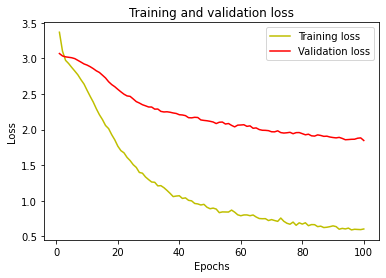

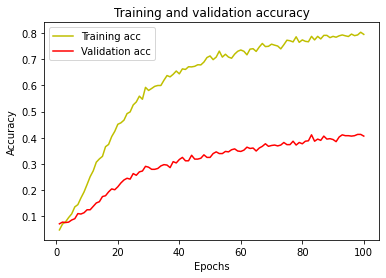

[[ 6  4  0  0  0  0  0  2  1  1  1  0  0  6  0  2  2  1  0  0]
 [ 5 15  0  0  0  0  0  2  3  1  0  0  0  2  0  0  2  0  0  0]
 [ 0  0  9  0  3  2  1  0  0  0  1  2  2  0  3  2  0  1  0  1]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 1  1  4  0  8  1  2  1  5  1  1  3  3  0  0  2  1  1  1  0]
 [ 0  0  4  0  1 10  0  0  0  0  0  3  2  0  1  1  0  1  6  2]
 [ 1  1  0  0  4  1 15  0  0  1  0  8  1  0  0  2  0  0  1  0]
 [ 4  5  0  1  0  0  0 11  1  1  0  0  0  3  0  1  0  0  1  0]
 [ 4  0  1  0  2  0  0  0 12  1  0  1  0  0  0  3  4  0  0  1]
 [ 2  5  0  0  0  0  2  1  5  9  0  0  3  0  0  3  4  1  1  0]
 [ 1  0  3  0  5  3  2  0  1  1  6  2  3  0  2  4  2  1  1  2]
 [ 0  0  2  0  3  0  2  0  1  1  2 14  2  0  1  1  0  0  3  1]
 [ 0  0  2  0  0  5  3  0  0  1  3  2  8  0  3  0  0  0  1  0]
 [ 1  1  0  6  0  0  0  2  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  1  0  1  0 15  0  0  0  2  3]
 [ 0  1  0  0  1  0  3  0  3  4  1  0  1  0  0 14  0  1

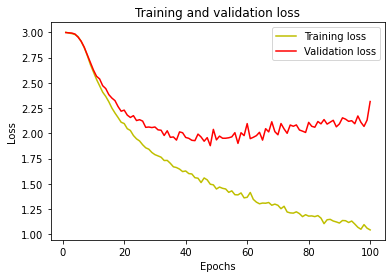

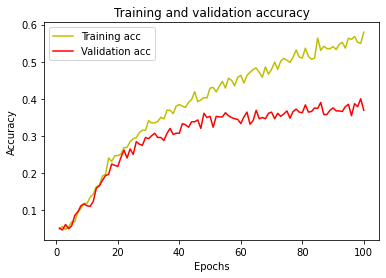

[[10  2  0  0  0  0  0  4  4  0  0  0  1  1  0  0  3  1  0  0]
 [ 7  9  0  0  0  0  0  2  1  3  1  0  0  0  0  1  6  0  0  0]
 [ 0  0  9  0  1  1  2  0  0  0  0  1  4  0  8  0  1  0  0  0]
 [ 1  0  0  1  0  0  0  1  0  0  0  0  0 27  0  0  0  0  0  0]
 [ 0  1  2  0 19  0  0  0  0  4  2  0  3  0  0  0  5  0  0  0]
 [ 0  0  3  0  0  1  0  0  0  0  0  5  2  0 17  1  0  0  2  0]
 [ 0  0  2  0  0  0 12  0  0  1  9  5  2  0  1  1  0  0  2  0]
 [ 3  2  0  0  0  0  0 15  0  0  0  0  0  5  0  0  1  2  0  0]
 [ 5  0  0  0  2  0  0  0 11  0  0  0  1  0  0  1  4  5  0  0]
 [ 6 10  0  0  1  0  2  0  1  2  2  0  1  0  0  4  6  1  0  0]
 [ 0  2  3  0  3  2  6  0  2  2  5  1  4  0  1  4  2  0  1  1]
 [ 0  0  1  0  2  0  5  0  0  0  4 16  2  0  0  1  0  0  2  0]
 [ 0  0  5  0  5  0  3  0  0  1  2  1  7  0  1  1  0  0  2  0]
 [ 1  0  0  2  0  0  0  4  0  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  2  0]
 [ 1  2  0  0  1  0  0  0  1  2  7  2  3  0  0  7  4  0

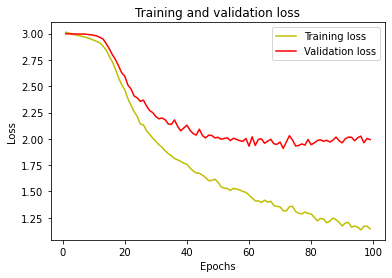

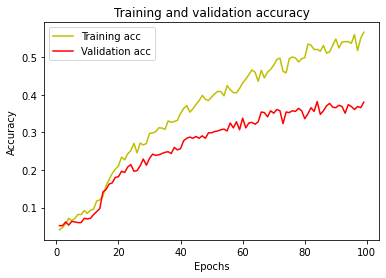

[[11  0  0  1  0  0  0  2  5  1  0  0  0  3  0  0  3  0  0  0]
 [ 1 13  0  0  0  0  0 12  0  2  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 12  0  2  1  0  0  0  0  1  1  2  0  5  3  0  0  0  0]
 [ 1  0  0 20  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1  0 15  1  0  0  3  0  7  0  4  0  1  1  0  3  0  0]
 [ 0  0  1  0  0  3  0  0  0  0  0  4  3  0  6  0  0  0 14  0]
 [ 0  4  0  0  0  0 17  0  0  1  1  9  1  0  0  2  0  0  0  0]
 [ 3  4  0  0  0  0  0 19  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 3  1  2  2  2  0  0  0  6  2  1  0  0  1  0  1  5  3  0  0]
 [ 3 12  0  0  0  0  2  1  0 12  0  0  0  0  0  2  4  0  0  0]
 [ 0  1  9  0  4  1  3  0  4  1  5  0  5  0  2  3  0  0  1  0]
 [ 0  0  9  0  0  1  6  0  0  0  1 12  0  0  0  1  0  0  3  0]
 [ 0  0  5  0  5  1  1  0  0  0  5  1  9  0  0  0  0  0  1  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0 15  0  0  0  5  0]
 [ 0  7  2  0  0  0  5  0  1  3  0  3  2  0  0  2  5  0

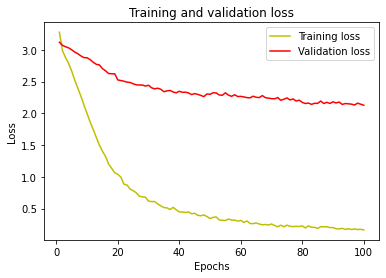

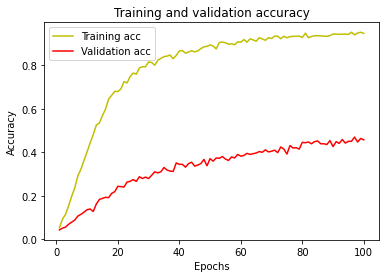

[[13  3  0  2  0  0  0  2  0  1  0  0  1  0  0  1  3  0  0  0]
 [ 2 18  0  2  0  1  0  0  1  3  1  0  0  0  0  1  1  0  0  0]
 [ 0  0 13  0  0  0  2  0  0  1  2  2  1  0  1  0  1  0  2  2]
 [ 1  0  0 18  0  0  0  5  0  1  0  0  0  5  0  0  0  0  0  0]
 [ 1  0  0  0 11  3  1  0  0  2  5  3  0  0  0  3  2  0  4  1]
 [ 0  1  2  0  0 15  1  0  0  0  3  1  2  0  0  2  0  0  3  1]
 [ 0  1  2  0  2  4 10  0  2  0  2  3  2  0  0  5  1  0  0  1]
 [ 1  3  0  3  0  0  0 17  1  0  1  0  0  1  0  0  1  0  0  0]
 [ 4  1  0  0  0  0  1  0 14  1  0  0  1  0  0  2  3  2  0  0]
 [ 0  2  1  0  3  0  1  3  7 10  1  2  1  1  0  1  3  0  0  0]
 [ 3  1  0  0  3  0  5  0  2  1 10  2  3  0  0  4  4  0  0  1]
 [ 0  0  1  0  0  2  2  0  0  0  2 18  0  0  0  2  2  0  4  0]
 [ 0  0  0  0  1  4  4  0  0  1  1  0 13  0  0  0  0  1  1  2]
 [ 2  2  0 12  0  0  0  1  0  0  0  0  0 10  0  0  2  0  0  0]
 [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0 18  0  0  0  1  1]
 [ 0  3  0  0  3  2  1  0  2  0  0  0  3  0  0  8  6  2

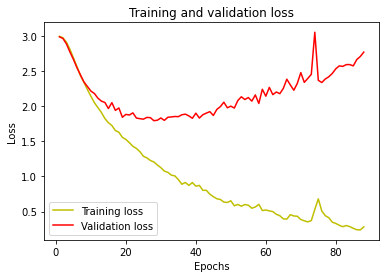

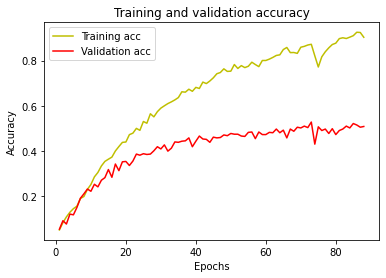

[[13  2  1  0  2  0  0  0  1  0  0  0  0  4  0  0  3  0  0  0]
 [ 3 13  0  0  1  0  0  2  3  4  2  0  0  0  0  1  1  0  0  0]
 [ 0  0 16  0  0  3  0  0  0  0  0  0  2  0  2  0  0  0  2  2]
 [ 0  0  0 19  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 1  1  1  0  9  1  2  0  3  1  1  0  5  0  0  3  4  2  2  0]
 [ 0  0  5  0  0 17  1  0  0  0  0  2  1  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  3 17  0  0  0  5  5  1  0  0  3  1  0  0  0]
 [ 0  2  0  3  0  0  0 17  2  0  0  0  0  1  0  2  0  1  0  0]
 [ 4  3  0  0  1  0  0  1 17  1  0  0  0  0  0  1  0  1  0  0]
 [ 1  9  0  0  1  0  0  0  3 11  2  1  0  0  0  5  3  0  0  0]
 [ 0  0  1  0  2  4  5  0  0  2 14  2  2  0  1  2  3  0  1  0]
 [ 0  0  0  0  0  7  2  0  0  0  1 14  1  0  0  4  0  0  3  1]
 [ 0  0  0  0  2  3  0  0  0  1  0  4 12  0  0  1  0  0  3  2]
 [ 2  0  0  4  0  0  0  0  1  0  0  0  0 22  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  5  2]
 [ 1  3  1  0  2  0  2  1  3  2  1  1  3  0  0  8  1  1

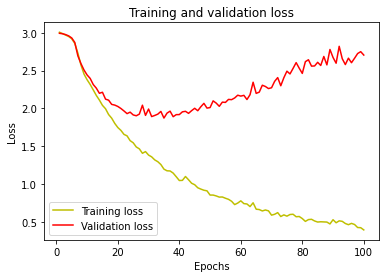

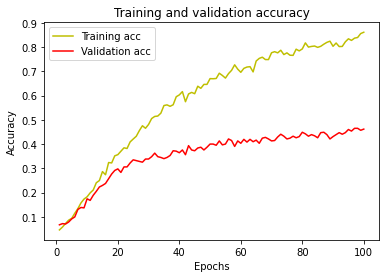

[[13  1  0  1  0  0  0  1  2  0  0  0  0  1  0  0  7  0  0  0]
 [ 3 10  0  0  0  0  3  4  2  2  0  0  0  1  0  4  1  0  0  0]
 [ 0  0 10  0  0  2  0  0  0  0  1  0  7  0  3  0  0  0  4  0]
 [ 0  0  0 18  0  0  0  1  0  0  0  0  0 10  0  0  0  1  0  0]
 [ 0  0  0  0 17  0  0  0  0  2  1  0 10  0  0  0  6  0  0  0]
 [ 0  0  2  0  0 17  0  0  0  0  0  2  0  0  3  0  0  0  7  0]
 [ 0  0  0  0  1  0 14  0  0  2  6  4  1  0  0  2  1  0  4  0]
 [ 2  4  0  4  0  0  0 14  1  0  0  0  0  1  0  0  0  2  0  0]
 [ 4  4  0  0  2  0  1  1  7  4  0  0  0  0  0  1  3  2  0  0]
 [ 3  2  0  0  0  0  0  0  7 15  3  0  1  0  0  0  5  0  0  0]
 [ 0  0  0  0  7  2  7  0  0  2  9  4  2  0  0  0  5  0  1  0]
 [ 0  0  1  0  0  3  6  0  0  0  1 15  1  0  0  3  0  0  2  1]
 [ 0  0  1  0  6  0  5  0  0  0  1  1 13  0  0  0  0  0  1  0]
 [ 3  0  0  7  0  0  0  1  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  2  0]
 [ 0  3  0  0  1  1  3  0  0  5  2  2  0  0  0 11  1  1

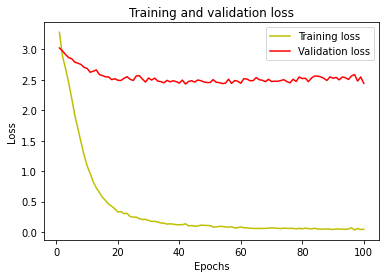

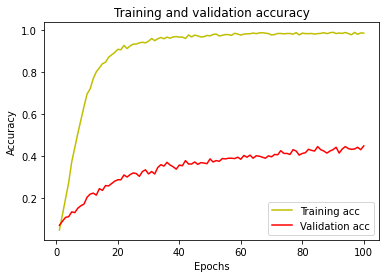

[[10  2  0  3  1  0  0  0  1  2  2  1  1  1  0  0  2  0  0  0]
 [ 1 11  1  1  0  0  2  3  3  2  0  0  1  2  0  3  0  0  0  0]
 [ 0  0 15  0  0  1  2  0  0  1  0  3  0  0  1  0  2  0  2  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  2  0  0 13  0  5  0  2  3  4  2  0  0  0  2  0  0  2  1]
 [ 0  1  2  0  2 16  0  0  0  1  1  2  1  0  1  2  0  0  2  0]
 [ 1  0  1  0  2  2 12  0  0  0  1  3  5  0  0  5  2  0  0  1]
 [ 0  0  2  1  0  0  2 17  1  0  0  0  0  5  0  0  0  0  0  0]
 [ 6  1  0  0  2  0  1  1  9  1  1  0  2  0  0  2  1  2  0  0]
 [ 3  3  2  0  1  1  0  3  1 10  0  2  3  0  0  2  5  0  0  0]
 [ 1  2  0  0  8  0  4  0  2  0  9  5  2  0  0  4  2  0  0  0]
 [ 0  0  2  0  2  3  2  0  0  1  2 17  1  0  0  0  2  0  1  0]
 [ 0  0  0  0  1  2  3  0  0  1  2  1 13  0  0  3  0  0  2  0]
 [ 1  0  0  8  0  0  0  0  0  0  0  0  0 19  0  0  1  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  1  0  0 18  0  0  0  1  1]
 [ 0  1  0  0  2  0  0  3  1  2  0  1  2  0  0 14  3  0

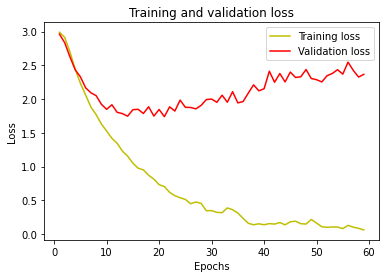

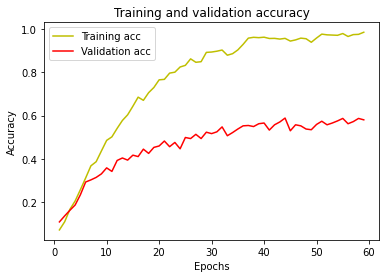

[[17  1  0  0  1  0  1  0  0  1  0  0  0  3  0  0  1  0  0  1]
 [ 3 18  0  0  0  0  0  1  0  1  0  0  0  2  0  5  0  0  0  0]
 [ 0  0 14  0  0  1  1  0  0  0  2  1  2  0  4  0  0  0  1  1]
 [ 1  0  0 20  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  1  2  0 16  0  0  0  2  1  3  2  7  0  1  0  0  0  1  0]
 [ 0  0  1  0  0 20  1  0  0  0  0  3  0  0  3  0  0  0  3  0]
 [ 0  0  2  0  0  3 26  0  0  0  0  1  0  0  0  3  0  0  0  0]
 [ 0  4  0  0  0  0  0 21  1  0  0  0  0  0  0  1  1  0  0  0]
 [ 5  3  1  0  1  0  0  1  9  2  2  0  0  0  0  2  2  1  0  0]
 [ 7  2  0  0  1  0  1  1  2 15  0  0  0  0  0  4  3  0  0  0]
 [ 1  0  3  0  3  1  3  0  0  2 13  4  3  0  0  5  0  0  0  1]
 [ 0  0  0  0  0  0  5  0  0  0  0 22  1  0  0  0  0  1  1  3]
 [ 0  0  4  0  2  0  2  0  0  3  0  3 12  0  0  1  0  0  1  0]
 [ 1  0  0  4  0  0  0  0  0  0  0  0  0 23  0  0  1  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 18  0  0  0  2  1]
 [ 0  4  1  0  1  1  2  0  0  1  3  1  1  0  0 14  1  0

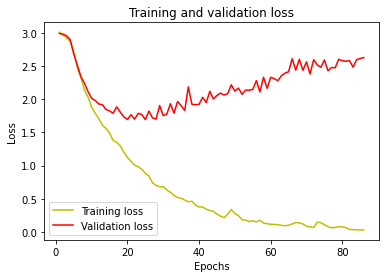

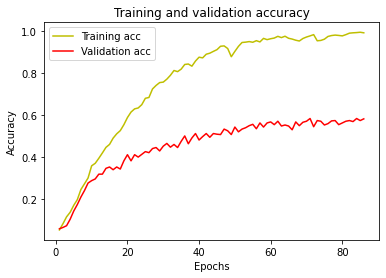

[[11  1  0  1  0  0  0  1  1  6  1  0  0  2  0  0  2  0  0  0]
 [ 0 14  0  0  0  0  1  7  0  5  0  0  0  0  0  1  2  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  1  0  3  0  4  0  0  0  3  1]
 [ 1  0  0 22  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  1  0 20  0  0  0  0  1  2  0  9  0  1  0  2  0  0  0]
 [ 0  0  2  0  0 19  0  0  0  0  0  3  5  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  0 25  0  0  0  1  6  0  0  0  1  0  0  1  0]
 [ 1  5  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  1  0  0  1  0  0  0 15  3  1  0  0  2  0  0  1  2  0  0]
 [ 2  4  0  0  0  0  1  1  4 16  4  0  0  0  0  3  1  0  0  0]
 [ 0  0  0  0  2  3  2  0  0  3 16  5  4  0  0  4  0  0  0  0]
 [ 0  1  1  0  0  2  2  0  0  0  3 20  1  0  0  1  0  0  2  0]
 [ 0  0  3  0  0  2  0  0  1  0  2  2 17  0  0  1  0  0  0  0]
 [ 1  0  0  4  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0 17  0  0  0  1  4]
 [ 0  3  3  0  0  1  1  0  0  4  5  1  3  0  0  8  1  0

In [43]:
window_size = 30
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test2_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  4%|███▍                                                                           | 81/1872 [00:00<00:02, 796.08it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1872/1872 [00:55<00:00, 34.04it/s]


[13.  9.  3. ... 13.  3. 12.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (40, 130)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 39, 16)            4176      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 38, 16)            528       
_________________________________________________________________
dropout_25 (Dropout)         (None, 38, 16)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 20)                12180     
Total params: 16,884
Tr

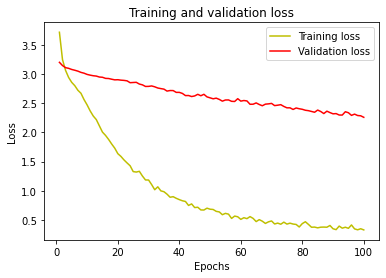

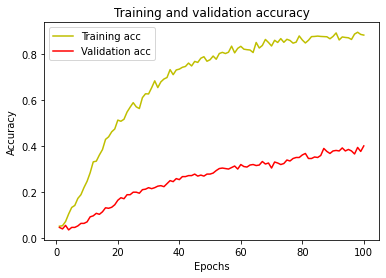

[[ 9  2  0  0  0  0  0  3  3  0  1  0  0  4  0  0  2  0  0  0]
 [ 1 12  0  0  1  0  2  3  0  1  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  5  0  1  1  0  0  0  0  0  2  1  0  2  1  1  0  5  1]
 [ 0  0  0 17  0  0  0  3  1  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  3  0  0  0  1  1  3  0  0  1  3  0  0  1]
 [ 0  0  1  0  0  7  0  0  0  0  2  1  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  3  1  9  0  1  3  2  0  1  0  0  1  0  0  4  0]
 [ 5  2  0  1  0  0  0  9  1  3  0  0  0  2  0  1  0  1  0  0]
 [ 0  0  0  0  2  1  0  4  9  0  0  0  1  0  0  1  1  1  1  1]
 [ 0  0  0  0  1  0  0  1  0  8  3  1  1  0  0  2  0  1  0  0]
 [ 0  2  1  0  0  1  4  1  0  2  5  2  1  0  0  1  0  1  0  1]
 [ 0  0  1  0  1  2  3  0  0  2  0  5  2  0  0  1  0  0  6  1]
 [ 0  0  3  0  2  0  2  0  1  2  0  1  8  0  0  0  1  0  3  0]
 [ 0  1  0  4  0  0  1  2  1  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  3  0  1  1  1  0  0  0  0  3  2  0  6  0  0  0  3  0]
 [ 0  0  0  0  2  1  0  1  6  2  3  1  0  0  0  8  1  0

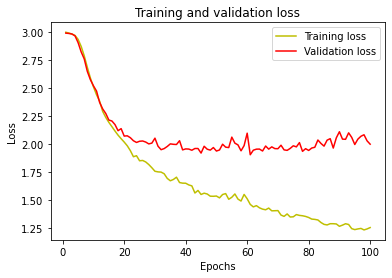

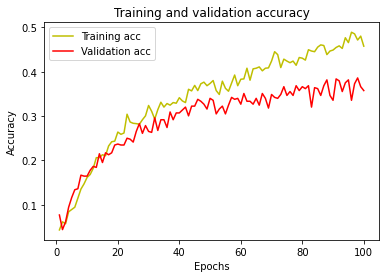

[[ 2  4  0  0  0  0  0  6  3  5  0  0  0  1  0  1  2  0  0  0]
 [ 3  6  0  0  0  0  0  2  1  4  0  0  0  0  0  4  1  1  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  4  1  0 10  0  0  0  1  2]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  2  0  0  3  0  6  0  0  1  2  3  2  0  0  3  0  1  1  0]
 [ 0  0  0  0  0  3  1  0  0  0  0  1  0  0  6  0  0  0  2  0]
 [ 0  0  0  0  5  0  8  0  0  0  4  4  4  0  0  1  0  0  0  0]
 [ 1  2  0  2  0  0  0 14  2  1  0  0  0  2  0  1  0  0  0  0]
 [ 2  1  0  0  0  0  0  0  7  2  1  0  0  0  0  2  4  3  0  0]
 [ 0  4  0  0  2  0  0  1  2  5  0  0  0  0  0  2  2  0  0  0]
 [ 0  1  0  0  2  0  6  0  2  1  1  3  2  0  0  2  0  1  0  1]
 [ 0  0  0  0  0  2  0  0  0  0  2 10  5  0  0  0  0  0  5  0]
 [ 0  0  0  0  2  2  3  0  0  0  3  6  2  0  2  1  0  0  2  0]
 [ 0  0  0 17  0  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 1  3  0  0  4  0  3  0  0  0  1  1  1  0  0 13  0  0

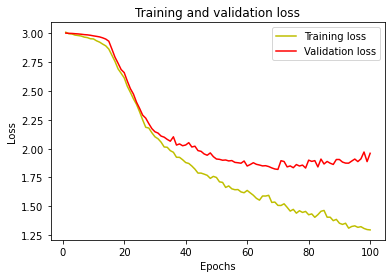

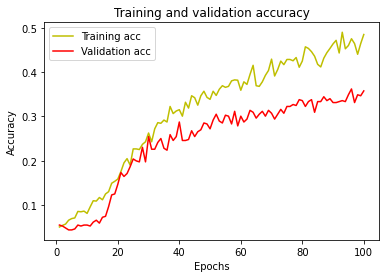

[[12  1  0  5  0  0  0  0  0  0  0  0  0  4  0  0  1  1  0  0]
 [ 4  6  0  0  0  0  0  3  2  6  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  3  0  0  3  0  0  0  0  1  4  6  0  2  0  0  0  0  1]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  2  0  0  5  1  1  0  0  3  3  2  2  0  0  3  1  0  0  1]
 [ 0  0  2  0  0  7  0  0  0  0  0  1  1  0  1  0  0  0  1  0]
 [ 0  0  1  0  8  0  3  0  0  0  5  4  4  0  0  1  0  0  0  0]
 [ 1  0  0  2  0  0  0 17  0  0  0  0  0  4  0  0  0  1  0  0]
 [ 4  2  0  1  0  0  0  4  0  6  0  0  0  0  0  1  1  2  0  1]
 [ 2  4  0  0  1  0  0  2  0  4  1  0  0  0  0  3  1  0  0  0]
 [ 0  1  0  0  2  1  2  0  0  4  3  3  2  0  0  2  0  2  0  0]
 [ 0  0  1  0  3  0  1  0  0  0  1  9  5  0  1  1  0  1  1  0]
 [ 0  0  4  0  5  3  4  0  0  0  1  4  2  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  1  0  0  0  1  0  7  0  0  0  0  0  0]
 [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0 13  0  0  0  4  0]
 [ 0  5  0  0  6  0  1  0  0  7  3  0  2  0  0  3  0  0

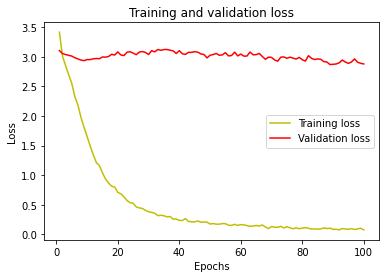

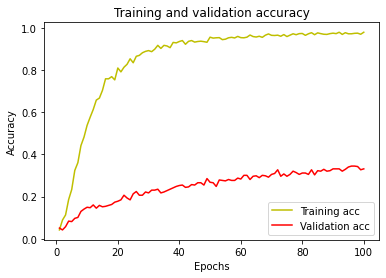

[[ 8  1  0  2  1  0  0  1  1  2  0  0  0  3  0  3  1  1  0  0]
 [ 2  8  1  0  1  0  3  1  1  2  0  0  0  0  0  2  1  0  0  0]
 [ 1  0  4  0  1  1  1  0  0  0  2  0  0  0  1  0  2  2  3  2]
 [ 5  2  0 11  0  0  0  2  0  2  0  0  0  4  0  0  0  0  0  0]
 [ 1  2  1  0  5  0  3  0  0  1  1  0  2  0  2  0  0  3  1  2]
 [ 0  0  3  0  0  3  1  0  2  0  0  0  0  0  1  1  0  0  2  0]
 [ 0  2  3  0  1  0 10  0  0  1  0  0  1  1  2  1  1  1  1  1]
 [ 1  4  0  1  0  0  1  9  0  1  2  0  1  2  0  2  1  0  0  0]
 [ 0  2  0  0  0  1  0  0  6  2  3  0  1  0  0  1  1  1  2  2]
 [ 1  0  2  0  0  0  0  1  1  6  2  1  1  0  0  1  1  0  1  0]
 [ 2  2  1  0  0  1  0  1  0  3  3  1  2  0  0  4  2  0  0  0]
 [ 0  1  0  0  1  1  6  0  0  0  1  3  2  0  1  0  1  0  4  3]
 [ 0  0  3  0  3  1  4  0  0  1  0  1  8  0  1  0  1  0  0  0]
 [ 0  0  0  4  0  0  0  2  0  0  0  0  0 12  0  1  2  0  0  0]
 [ 0  0  2  0  0  1  3  0  0  0  1  0  1  0 10  0  0  0  0  2]
 [ 3  2  0  0  2  0  1  1  2  0  4  1  2  0  0  7  1  1

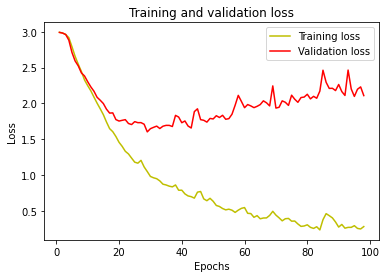

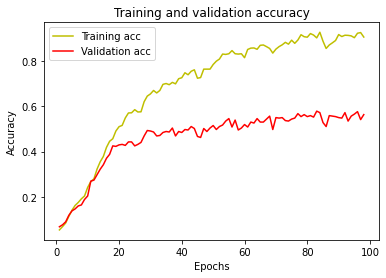

[[16  0  1  0  0  0  0  0  0  0  0  0  0  2  0  0  5  0  0  0]
 [ 0 14  0  0  0  0  0  2  4  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  7  0  0  1  0  0  0  0  2  0  6  0  2  0  0  0  2  0]
 [ 0  1  0 22  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  1  0  0 11  0  1  0  1  6  3  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  9  1  0  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  2  0  0  1  0 12  1  0  3  2  3  0  0  0  2  0  0  0  0]
 [ 0  2  0  0  0  0  0 21  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 1  5  0  0  1  0  0  0  8  2  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  1  0  0  1  0 15  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  3  0  1  0  1  5  3  1  0  0  0  2  0  0  4  0]
 [ 0  0  0  0  0  1  3  0  0  0  0 11  4  0  1  1  0  1  1  1]
 [ 0  0  0  0  5  1  2  0  0  1  1  1 10  0  0  0  0  0  2  0]
 [ 0  0  0  4  0  0  0  0  1  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0  0  5  0  0  0  0  0  0  0  0 12  0  0  0  2  0]
 [ 0  1  0  0  2  0  2  1  0  4  2  1  0  0  0 13  1  0

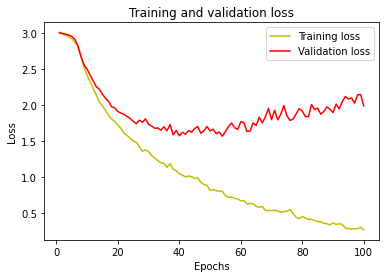

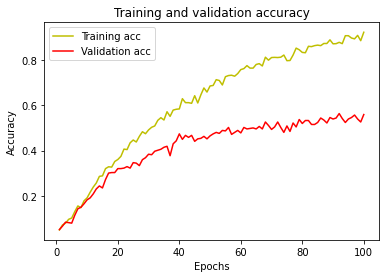

[[13  4  0  2  0  0  0  0  3  0  0  0  0  2  0  0  0  0  0  0]
 [ 2 13  0  0  0  0  0  0  2  2  0  0  0  0  0  1  1  1  0  0]
 [ 0  0  9  0  2  2  2  0  0  0  0  0  3  0  0  1  0  0  0  1]
 [ 1  0  0 20  0  0  0  2  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  2  0  0 11  0  0  0  1  0  0  2  4  0  0  0  2  2  0  0]
 [ 0  0  2  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  1  3  0  1  1  7  0  0  0  5  5  1  0  0  2  0  0  0  0]
 [ 1  0  0  1  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 12  3  0  0  0  0  0  0  1  4  0  0]
 [ 0  1  0  0  1  0  1  0  0 10  1  0  0  0  0  4  0  0  0  0]
 [ 0  1  0  0  0  0  5  0  0  0  5  1  3  0  0  4  2  1  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  1 16  0  0  0  3  0  0  1  1]
 [ 0  0  2  0  6  0  3  0  0  0  0  0 11  0  0  1  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  0  0  0  0  0 10  0  0  1  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  1  0 13  0  0  0  5  0]
 [ 0  1  0  0  1  0  1  0  1  5  3  2  0  0  0 13  0  0

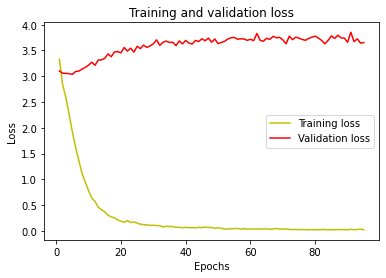

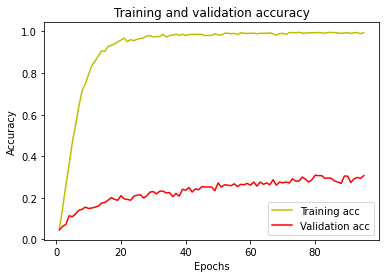

[[ 6  1  0  1  0  0  1  3  3  2  1  0  0  4  0  2  0  0  0  0]
 [ 2  8  1  1  0  1  0  1  1  1  0  1  1  1  0  1  2  0  0  0]
 [ 1  2  1  0  2  0  2  0  1  1  2  0  1  0  1  0  1  0  4  1]
 [ 2  1  0 12  0  0  0  5  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 2  1  1  0  2  0  1  0  1  1  3  4  2  0  3  3  0  0  0  0]
 [ 1  1  0  0  0  4  0  0  1  0  0  1  0  1  0  2  0  0  2  0]
 [ 0  2  1  1  3  0  4  0  1  6  1  1  3  0  1  0  2  0  0  0]
 [ 0  2  0  3  0  0  0  9  1  2  0  1  0  4  0  1  1  0  1  0]
 [ 1  2  0  0  0  2  0  0  9  3  1  0  0  0  1  1  0  2  0  0]
 [ 0  0  1  1  1  1  1  1  0  6  2  0  0  2  0  1  1  0  0  0]
 [ 0  1  1  0  0  2  0  3  4  2  2  2  0  2  2  1  0  0  0  0]
 [ 0  0  0  0  0  3  3  0  0  3  1  6  3  0  0  2  0  0  2  1]
 [ 0  0  3  0  0  1  2  1  2  3  0  2  4  0  3  2  0  0  0  0]
 [ 0  2  0  1  0  0  0  0  0  2  0  0  0 13  0  2  1  0  0  0]
 [ 0  2  0  0  1  2  0  0  1  2  0  1  0  0  8  1  0  0  2  0]
 [ 2  2  2  0  0  1  0  0  7  1  3  1  1  1  0  4  0  0

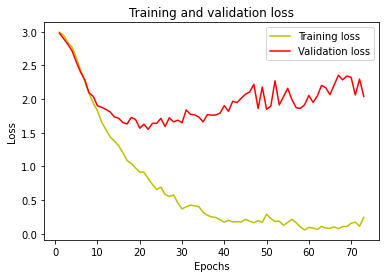

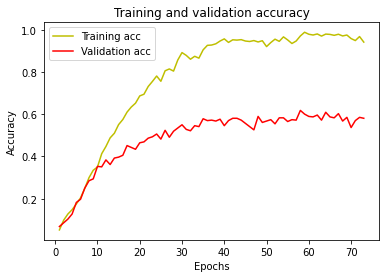

[[14  4  0  1  1  0  0  0  1  2  0  0  0  0  0  0  1  0  0  0]
 [ 1 19  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 10  0  1  0  3  0  0  0  1  0  4  0  0  0  1  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  1  1  0 13  0  0  0  0  1  3  0  2  0  0  0  3  0  0  0]
 [ 0  0  1  0  0  8  2  0  0  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  1  0  0  0  1 13  0  0  0  4  1  2  0  0  3  0  0  0  1]
 [ 0  2  0  3  0  0  0 17  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  0  1  9  5  0  0  1  0  0  0  1  1  1  0]
 [ 1  2  0  0  0  0  0  0  0 10  1  0  0  0  0  2  1  1  0  0]
 [ 0  0  1  0  0  0  1  0  1  2 12  0  0  0  0  2  1  1  0  1]
 [ 0  0  1  0  0  3  6  0  0  0  3  8  0  0  0  0  0  0  1  2]
 [ 0  0  1  0  1  0  1  0  0  0  5  1 10  0  0  3  1  0  0  0]
 [ 3  0  0  5  0  0  0  2  1  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  1  0  0  0 14  0  0  0  1  0]
 [ 0  2  1  0  0  0  1  1  1  6  1  0  1  0  0 11  0  1

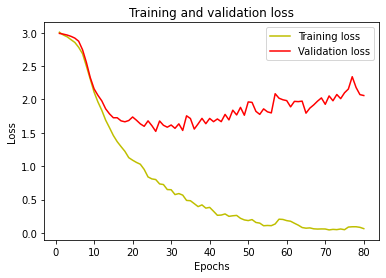

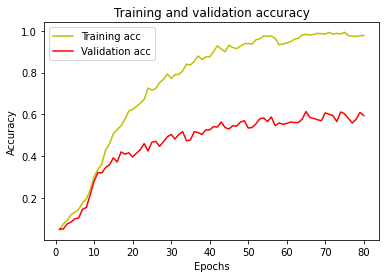

[[13  1  0  1  0  0  0  0  3  0  0  0  0  3  0  0  3  0  0  0]
 [ 1 16  0  0  0  0  0  1  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  3  1  0  0  0  0  1  0  1  0  1  0  0  1  1  0]
 [ 0  0  0 21  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  1  0 16  0  0  0  2  0  1  0  1  0  0  0  2  0  1  0]
 [ 0  0  0  0  0  7  3  0  0  0  0  1  0  0  1  0  0  0  1  0]
 [ 0  2  0  0  0  0 19  0  0  0  1  2  2  0  0  0  0  0  0  0]
 [ 0  3  0  3  0  0  0 18  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0 11  5  0  0  1  0  0  0  1  2  0  0]
 [ 0  2  0  0  0  0  0  0  2  9  2  0  0  0  0  2  1  0  0  0]
 [ 0  0  0  0  2  0  1  0  2  6  2  2  3  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  3 14  1  0  0  2  0  0  0  0]
 [ 0  0  2  0  2  3  1  0  0  1  2  0 11  0  0  0  1  0  0  0]
 [ 0  0  0  4  0  0  0  0  1  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  4  0]
 [ 0  5  0  0  1  0  0  0  1  2  4  2  0  0  0 10  2  0

In [44]:
window_size = 40
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test2_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  5%|███▋                                                                           | 69/1497 [00:00<00:02, 689.28it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1497/1497 [00:45<00:00, 32.96it/s]


[ 5. 19. 11. ... 16.  4. 15.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******** 1 ********
inputShape: (50, 130)
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 49, 16)            4176      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 48, 16)            528       
_________________________________________________________________
dropout_34 (Dropout)         (None, 48, 16)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 20)                15380     
Total params: 20,084
Tr

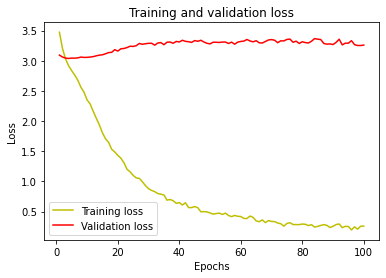

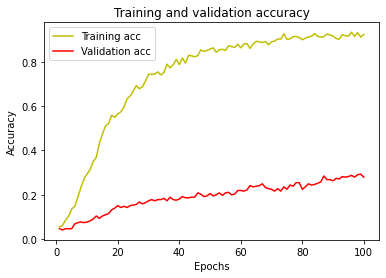

[[ 7  1  2  0  0  0  0  0  3  1  0  0  0  1  0  1  1  0  0  0]
 [ 3  5  3  0  0  1  1  4  2  1  0  1  1  1  0  1  1  0  0  0]
 [ 0  0  5  0  0  2  1  0  0  2  0  2  1  0  0  1  1  0  2  0]
 [ 3  0  0  8  0  0  0  1  0  0  0  0  0  3  0  0  1  0  0  0]
 [ 1  0  1  0  7  0  1  0  1  2  1  0  1  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  8  1  0  0  0  2  1  0  0  0  0  0  0  1  1]
 [ 0  1  1  0  0  4  5  0  0  1  0  1  0  0  1  1  0  0  0  0]
 [ 5  4  0  0  0  1  2  3  0  0  0  1  1  2  0  0  0  0  2  0]
 [ 4  0  1  1  2  0  1  1  3  1  1  0  0  0  0  0  2  3  0  1]
 [ 1  0  1  0  3  0  0  0  1  5  0  0  1  0  0  2  2  1  0  0]
 [ 0  2  2  0  3  1  0  0  0  1  3  4  0  0  1  1  3  0  0  0]
 [ 0  0  3  0  1  1  3  2  0  1  0  3  0  0  0  1  0  0  3  2]
 [ 0  0  3  0  1  3  2  0  0  2  0  1  1  0  0  1  1  0  1  1]
 [ 4  0  0  4  0  0  0  1  0  1  0  0  0 10  0  1  2  0  0  0]
 [ 0  0  1  0  0  2  0  0  0  0  1  2  0  0  6  0  0  0  3  2]
 [ 2  3  1  0  1  1  0  1  0  1  0  1  4  2  1  5  0  0

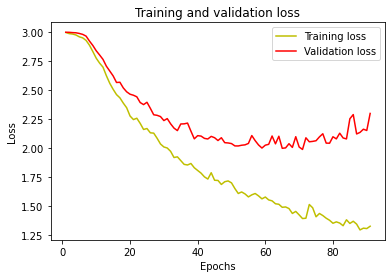

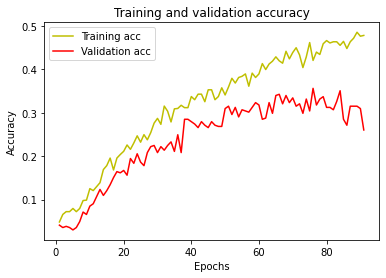

[[ 8  0  0  2  0  0  0  0  0  0  0  0  0  1  0  4  2  0  0  0]
 [ 2  5  0  1  0  0  4  1  0  5  3  0  0  2  0  1  1  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  2  2  0  2  0  0  0  5  0]
 [ 3  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  4  0  0  0  2  6  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  2  1  0  0  0  0  2  7  2]
 [ 0  0  0  0  1  0  7  0  0  1  2  1  1  0  0  1  0  1  0  0]
 [ 2  0  1 15  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 2  2  0  0  0  0  2  1  1  0  1  0  0  0  0 11  1  0  0  0]
 [ 0  2  0  0  3  0  0  1  1  2  1  0  0  0  0  5  2  0  0  0]
 [ 0  0  0  0  1  1  3  0  0  1  2  4  0  0  0  4  2  1  1  1]
 [ 0  0  0  0  0  3  2  0  0  0  0  5  5  0  0  1  0  1  2  1]
 [ 0  0  2  0  0  0  1  0  0  0  0  3  7  0  1  0  0  1  1  1]
 [ 0  1  0 18  0  0  0  2  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  1]
 [ 0  0  3  0  2  0  1  0  4  1  0  1  2  0  0  9  0  0

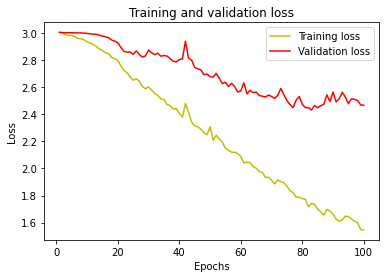

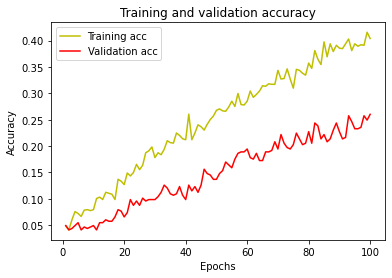

[[ 4  2  0  0  0  0  2  0  1  0  0  0  0  4  0  2  0  0  1  1]
 [ 3  7  0  1  0  1  2  0  0  0  4  3  0  0  0  4  0  0  0  0]
 [ 0  0  3  0  2  0  0  0  0  0  0  1  4  0  0  0  2  0  5  0]
 [ 1  0  0 13  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  2  0  2  0  0  0  0  0  2  0  3  0  1  0  1  0  4  0]
 [ 1  0  0  0  2  0  4  0  0  0  3  1  1  0  0  1  0  0  2  0]
 [ 1  0  1  0  0  2  2  0  0  0  1  4  0  0  0  3  1  0  0  0]
 [ 2  0  0  2  0  1  0 12  0  0  0  1  0  1  0  1  0  1  0  0]
 [ 1  2  0  4  1  0  0  1  0  0  2  1  0  3  0  2  0  2  1  1]
 [ 2  1  0  2  0  1  0  1  2  4  0  0  0  1  1  0  0  1  0  1]
 [ 0  0  0  0  2  3  4  0  2  0  5  0  2  0  1  1  0  0  1  0]
 [ 0  0  1  0  4  2  1  0  0  0  4  0  3  0  1  2  0  0  2  0]
 [ 0  0  4  0  1  0  0  0  0  0  0  1  2  0  0  1  4  0  4  0]
 [ 2  1  0  9  0  0  0  2  0  0  0  0  0  8  0  1  0  0  0  0]
 [ 0  0  5  0  1  0  0  0  0  0  1  0  1  0  2  0  3  1  3  0]
 [ 2  2  0  1  2  0  2  1  2  0  3  1  1  0  1  3  0  0

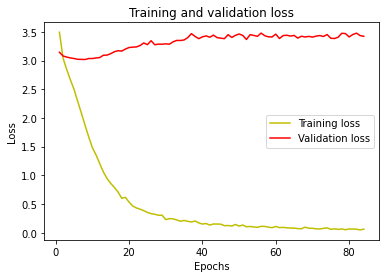

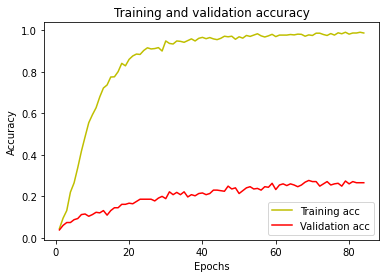

[[ 5  1  0  0  0  0  2  1  4  0  0  0  0  3  0  0  1  0  0  0]
 [ 2  2  0  1  1  1  2  2  1  3  2  1  2  2  0  1  0  0  1  1]
 [ 0  0  1  0  1  1  3  0  0  1  2  2  2  0  0  0  0  0  4  0]
 [ 1  0  0  8  0  0  0  1  0  0  1  0  0  4  0  1  0  0  0  0]
 [ 2  0  1  0  4  0  0  1  2  1  0  1  1  0  1  0  0  0  2  0]
 [ 0  0  1  0  0  7  1  1  0  0  0  1  1  0  2  0  1  0  0  0]
 [ 0  0  1  0  1  0  7  0  0  0  3  1  0  0  1  0  0  0  1  0]
 [ 3  1  1  1  0  0  1  5  0  0  5  0  1  1  0  0  0  0  2  0]
 [ 0  1  1  0  0  2  2  2  0  2  2  0  2  0  0  3  1  0  1  2]
 [ 0  1  1  0  1  1  0  0  0  9  1  0  2  0  0  1  0  0  0  0]
 [ 3  2  2  0  0  1  5  1  0  1  3  0  1  0  1  0  0  0  1  0]
 [ 1  1  2  0  0  6  2  0  1  1  0  3  0  0  1  0  0  0  2  0]
 [ 0  1  3  0  1  1  2  0  0  1  0  1  2  0  3  0  0  0  1  1]
 [ 0  1  0  7  0  0  1  3  0  0  1  0  0  6  0  0  4  0  0  0]
 [ 0  0  0  0  0  3  1  0  0  0  0  2  1  0  7  1  0  1  0  1]
 [ 1  0  2  0  2  1  2  0  2  0  2  0  3  1  2  2  1  0

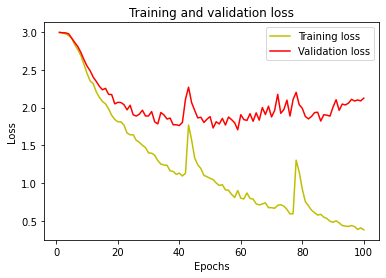

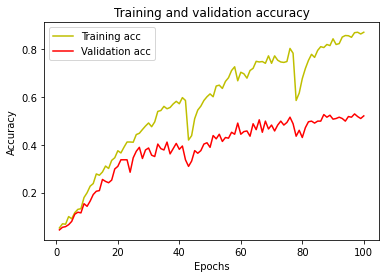

[[13  0  0  0  0  0  0  0  0  1  0  0  0  1  0  1  1  0  0  0]
 [ 3 14  0  0  0  0  2  0  0  2  2  0  0  0  0  1  1  0  0  0]
 [ 0  0  9  0  3  0  0  0  0  0  1  0  2  0  2  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  2  0  6  1  1  0  0  0  2  0  2  0  2  0  0  0  0  0]
 [ 0  0  1  0  1  5  0  0  0  0  0  3  1  0  1  0  0  0  3  0]
 [ 0  0  0  0  1  0 10  0  0  2  1  1  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0 16  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 5  0  1  0  0  0  0  0  5  1  2  0  0  0  0  0  6  1  0  0]
 [ 1  2  0  0  0  0  1  0  0  7  1  0  0  0  0  5  0  0  0  0]
 [ 0  0  1  0  6  2  2  0  0  2  6  0  0  0  0  1  1  0  0  0]
 [ 0  1  0  0  2  2  4  0  0  1  2  4  2  0  0  0  0  0  2  0]
 [ 0  0  3  0  4  2  1  0  0  1  1  0  5  0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0 13  0  0  0  2  0]
 [ 0  4  0  0  0  0  0  0  1  6  3  1  0  0  0  6  1  1

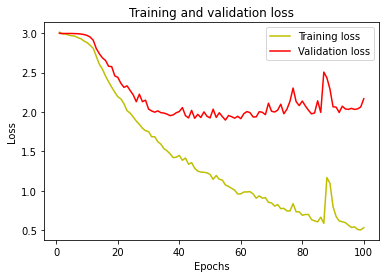

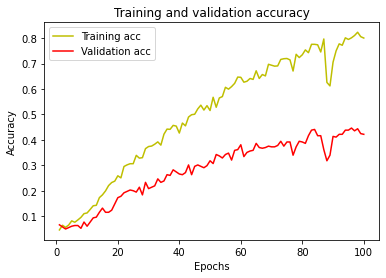

[[12  1  0  1  0  0  0  0  1  0  0  0  0  1  0  1  0  0  0  0]
 [ 5  6  0  0  1  1  0  0  0  3  1  0  0  0  0  7  1  0  0  0]
 [ 0  0  6  0  1  3  0  0  0  0  0  5  2  0  0  0  0  0  0  0]
 [ 1  0  0  9  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  1  0  5  0  1  0  0  1  1  2  4  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  7  2  0  0  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  3  5  0  0  1  2  0  3  0  0  0  0  0  1  0]
 [ 1  0  0  1  0  0  0 13  2  0  0  0  0  3  0  0  0  1  0  0]
 [ 1  2  0  3  0  0  0  1  9  1  0  0  0  0  0  1  0  3  0  0]
 [ 1  2  0  0  0  2  2  0  0  8  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  3  0  0  0  2  8  1  1  0  0  1  1  1  0  0]
 [ 0  0  0  0  1  4  1  0  0  0  0  6  3  0  1  0  0  0  2  2]
 [ 0  0  2  0  4  2  1  0  1  0  2  1  2  0  0  0  1  1  0  0]
 [ 0  0  0 11  0  0  0  1  0  0  0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 12  0  0  0  4  0]
 [ 2  3  0  0  1  0  1  0  3  4  1  0  1  0  0  4  3  0

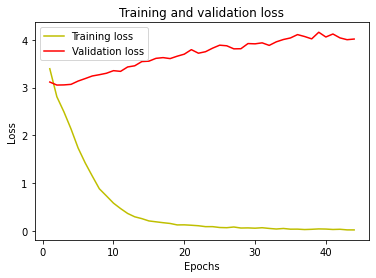

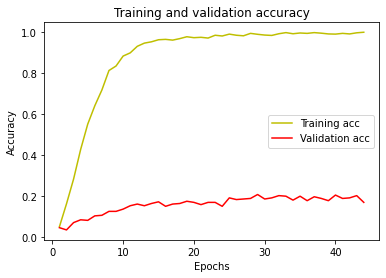

[[4 0 1 0 0 0 1 1 3 1 1 1 0 2 1 0 0 0 1 0]
 [2 3 1 0 2 1 2 0 3 3 1 1 0 1 0 1 3 0 1 0]
 [1 0 3 0 0 0 3 0 0 2 1 0 1 2 1 0 0 0 3 0]
 [2 0 1 7 1 0 1 0 0 0 1 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 4 1 0 1 2 1 1 0 0 1 2 0 0 0 1 1]
 [0 1 2 0 0 1 1 1 2 2 0 1 0 0 0 2 0 0 2 0]
 [0 0 2 0 0 1 4 0 0 0 0 0 2 0 1 0 3 0 1 1]
 [0 1 2 1 1 0 2 4 0 2 2 1 0 0 0 3 0 0 2 0]
 [2 1 1 0 0 1 3 2 2 2 1 0 1 0 0 1 0 2 2 0]
 [0 1 0 0 2 1 1 1 0 4 0 0 1 1 1 0 3 0 1 0]
 [1 1 1 0 2 0 1 0 2 1 2 2 1 0 3 3 0 0 1 0]
 [2 0 3 0 1 1 2 2 0 2 1 1 0 0 3 1 0 0 1 0]
 [1 0 2 0 2 1 0 1 3 1 1 1 0 0 1 1 2 0 0 0]
 [1 1 2 6 0 0 1 1 1 1 0 1 0 4 0 3 0 0 1 0]
 [0 0 2 0 1 1 0 1 1 0 2 1 3 0 2 2 0 1 0 0]
 [1 2 1 0 2 0 0 1 3 1 0 0 2 2 0 3 2 2 1 0]
 [3 0 3 1 2 1 2 0 3 2 0 0 1 1 0 1 0 0 0 0]
 [0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 6 1 2]
 [0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 2 1]
 [0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 6 1 6]]
              precision    recall  f1-score   support

           0       0.20      0.24      0.22        17
           1       0.27      0

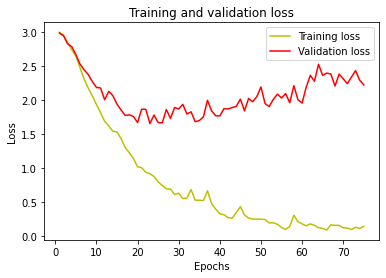

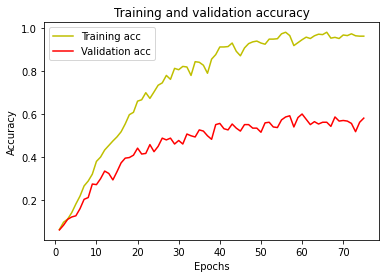

[[12  4  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 2 15  0  0  0  0  0  1  0  2  1  0  0  1  0  0  3  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  4  0  1  0  0  0  5  0]
 [ 0  1  0 10  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  1  0  0  0  0  0  3  0  0  0  1  1  1  1]
 [ 0  0  0  0  0 10  0  0  0  0  1  1  0  0  1  0  0  0  2  0]
 [ 0  0  0  0  0  0  8  0  0  0  2  2  1  0  0  2  0  0  0  0]
 [ 0  2  0  3  0  1  0 14  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 5  2  0  0  1  0  0  0  8  0  0  0  0  0  0  1  3  1  0  0]
 [ 0  1  0  0  0  0  0  0  0 14  1  0  0  0  0  0  1  0  0  0]
 [ 0  0  1  0  1  2  0  0  1  0  9  2  1  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  3  3  0  1  0  1 10  0  0  0  1  0  0  1  0]
 [ 0  0  0  0  1  2  0  0  0  0  5  0  5  0  2  0  0  0  2  0]
 [ 2  0  0  6  0  0  0  0  1  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 15  0  0  0  1  0]
 [ 0  3  1  0  0  0  5  0  1  2  1  0  0  0  0  8  1  1

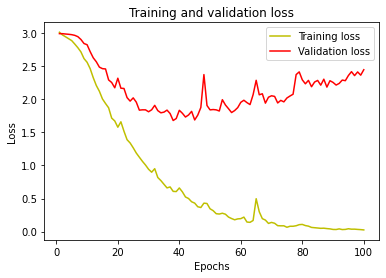

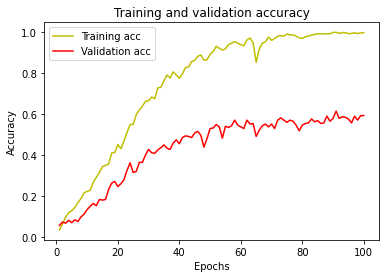

[[12  0  0  0  0  0  0  1  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 10  0  0  1  0  2  1  2  2  0  0  0  0  0  5  1  0  0  0]
 [ 0  0 10  0  1  0  1  0  0  0  0  0  1  0  3  0  0  0  1  0]
 [ 1  0  0 10  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  1  2  0  9  0  0  0  0  0  1  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  2  0  0  0  0  1  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  8  0  0  1  5  0  0  0  0  1  0  0  0  0]
 [ 0  2  0  1  0  0  0 13  0  3  0  0  0  1  0  0  1  0  0  0]
 [ 0  1  0  0  1  0  0  0 12  0  0  1  0  3  0  1  0  2  0  0]
 [ 0  3  0  0  0  0  1  2  0  9  1  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  2  0  2  0  0  0 11  0  4  0  0  1  1  0  0  0]
 [ 0  0  0  0  1  2  3  0  0  0  1  7  4  0  0  0  0  0  2  0]
 [ 0  0  3  0  0  1  0  0  0  0  4  0  8  0  0  1  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  1  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  1  1  5  0  0  2  1  1  0  0  0 11  1  0

In [45]:
window_size = 50
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test2_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

  5%|███▋                                                                           | 58/1247 [00:00<00:02, 564.55it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1247/1247 [00:35<00:00, 35.30it/s]


[10. 12.  6. 16.  3. 16. 13.  7. 18.  7. 17. 10. 17. 14.  8.  9. 20.  1.
  1. 11.  6.  9. 15. 11. 12.  2.  6. 11. 12.  7.  1. 20.  8. 17. 17. 10.
  7.  4. 10.  2. 16.  9.  1. 19. 18.  5. 15. 17. 11. 20. 14. 18.  2.  2.
 18. 15. 19.  1. 19. 15. 16.  9.  6. 18.  1.  7. 16. 17.  5. 10.  1.  9.
 20.  1. 15.  8.  2. 20. 20.  3.  8. 15.  9. 20.  3. 15. 20.  3. 13.  3.
  9. 14. 16.  4. 19.  3. 11. 13. 10. 19. 11.  8. 13.  5. 17. 18.  1. 15.
 12. 16.  1.  5.  4.  7.  7. 15. 16. 11. 19.  6. 16. 12.  7. 12. 11. 17.
 15. 14. 16.  6. 13. 18. 17. 13.  9. 19.  9. 16.  9. 18.  3. 16.  8. 20.
 20. 14. 16. 14. 18.  2.  3.  7. 11.  5.  6.  4.  1.  7.  5. 16.  5. 15.
  8.  5. 15.  6. 12. 10. 12. 17.  8. 10. 10. 17. 18. 13. 18. 19. 10. 20.
 12.  7. 17. 18.  8.  7. 20. 20.  3.  1.  4. 10. 14. 10.  5.  1.  9. 20.
 19. 10. 18. 14. 14. 12. 10.  5. 10. 17.  2. 11.  1.  4.  2. 11. 15. 14.
  2. 18. 17. 19. 19.  2.  9. 19.  4. 18. 15.  5. 11. 16.  8.  2. 17.  1.
 12.  5.  6. 20. 10.  4. 16. 20.  2. 11.  7. 16. 19

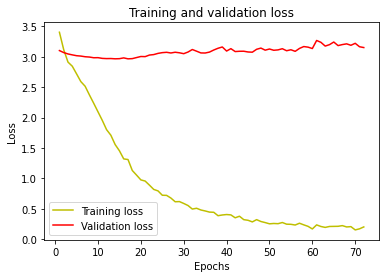

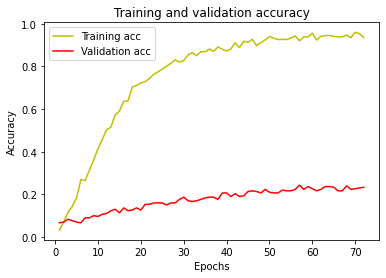

[[1 0 1 0 0 0 0 1 1 1 0 0 0 4 0 2 0 0 1 0]
 [1 4 2 0 0 1 0 1 0 1 2 1 0 0 2 1 1 1 0 0]
 [0 1 2 0 2 0 0 2 1 0 0 0 1 0 0 0 3 0 0 0]
 [3 0 0 5 1 0 0 5 0 0 0 0 0 4 0 1 1 2 0 0]
 [0 1 0 0 3 1 0 0 0 0 1 2 1 1 2 0 0 0 0 1]
 [1 0 2 0 2 1 2 1 0 0 2 1 3 0 1 1 0 0 1 1]
 [0 1 1 0 0 0 4 0 0 0 1 1 1 0 0 0 0 0 1 0]
 [1 2 0 1 0 1 0 3 2 4 0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 2 4 3 0 2 1 3 1 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 1 2 1 2 2 1 0 0 1 1 1 0]
 [0 1 0 0 2 0 0 0 2 0 3 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 2 1 2 0 0 1 0 4 3 0 1 0 0 0 0 0]
 [0 0 3 0 1 0 2 0 0 1 1 1 3 1 1 0 0 1 0 0]
 [3 1 0 5 0 0 0 1 2 0 0 0 0 7 0 2 1 0 0 0]
 [0 1 1 0 1 0 1 0 0 0 0 3 3 0 4 0 0 0 1 0]
 [1 3 0 0 0 1 0 0 2 0 1 2 0 1 1 2 0 0 0 1]
 [0 0 0 2 1 0 0 0 4 0 1 0 2 2 0 0 1 1 2 0]
 [0 0 1 0 2 0 0 0 0 0 0 1 0 1 0 0 0 8 0 5]
 [0 0 0 0 0 1 2 0 0 0 1 2 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 9]]
              precision    recall  f1-score   support

           0       0.08      0.08      0.08        12
           1       0.24      0

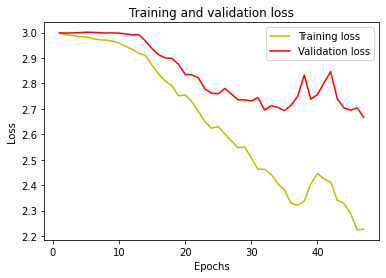

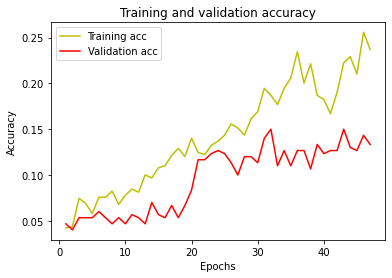

[[ 3  0  0  0  6  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  3  1  1  0  3  0  0  1  0  1  0  1  0  6  0]
 [ 3  0  0  0  2  1  1  1  0  0  0  0  1  0  0  0  2  0  1  0]
 [ 8  0  0  4  7  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  1  3  0  0  0  1  0  0  2  1  0  0  0  4  1  0  0]
 [ 0  0  0  0  0  0  4  3  0  1  0  0  0  0  0  1  1  0  9  0]
 [ 1  0  0  0  1  0  3  0  0  0  0  1  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  1  0  6  0  1  0  0  0  0  0  0  0  0  7  1]
 [ 1  0  2  0  4  1  0  0  0  3  0  0  1  0  0  1  4  0  1  0]
 [ 1  0  0  0  1  0  1  1  0  1  0  0  1  0  0  0  5  0  3  0]
 [ 1  0  0  0  1  0  2  0  0  0  0  0  2  0  0  0  4  0  0  0]
 [ 0  0  2  1  1  0  4  0  0  0  2  1  0  0  0  0  1  0  2  0]
 [ 0  1  0  0  2  0  0  0  0  0  2  0  3  0  0  0  6  0  1  0]
 [ 3  0  0  0  5  0  0  1  1  0  2  0  4  1  0  0  5  0  0  0]
 [ 0  1  0  1  3  0  1  0  0  2  0  0  1  0  0  0  5  0  1  0]
 [ 1  1  0  0  0  0  0  0  0  4  1  0  5  0  0  0  3  0

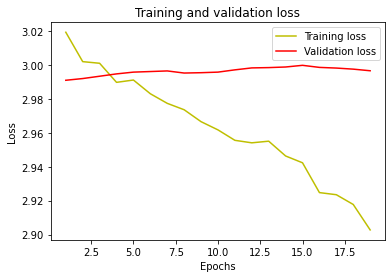

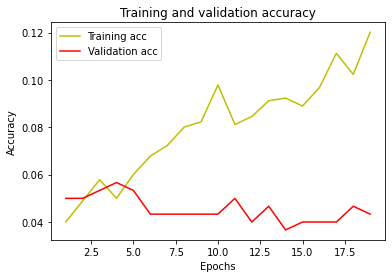

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1 0 1 0 0 0 0 0 0 1 0 0 2 0 0 0 0 1 6 0]
 [2 0 3 0 1 0 0 1 0 1 0 0 1 0 0 1 3 0 4 1]
 [3 0 1 0 0 1 0 1 0 0 0 0 4 0 0 0 0 1 0 1]
 [2 0 1 1 1 0 2 2 1 4 0 1 1 0 1 1 1 0 1 2]
 [1 0 0 0 0 1 0 0 1 2 0 0 4 0 1 0 1 0 1 1]
 [2 0 1 1 2 0 0 1 4 0 0 0 3 0 1 0 2 0 2 0]
 [1 0 0 0 0 0 0 0 3 1 0 0 2 0 0 0 0 1 2 0]
 [2 0 0 1 0 1 0 3 2 2 0 0 0 0 0 0 0 0 5 0]
 [5 0 1 0 2 1 1 0 1 1 1 0 1 0 0 0 2 0 2 0]
 [2 0 2 0 1 0 0 1 1 2 1 0 2 0 0 1 0 0 1 0]
 [0 0 2 0 0 0 0 0 0 2 1 0 3 0 0 0 0 0 2 0]
 [1 1 1 0 0 0 0 0 2 1 1 0 1 0 0 1 1 1 3 0]
 [2 0 2 0 1 1 0 0 0 1 0 0 2 0 0 0 3 1 2 0]
 [2 0 1 0 0 0 1 2 2 4 1 0 1 0 0 0 1 0 6 1]
 [3 0 0 0 1 1 0 0 1 2 2 0 2 0 0 1 0 2 0 0]
 [1 0 2 1 0 1 1 2 2 1 0 0 3 0 0 0 0 0 0 1]
 [1 0 3 0 4 1 0 0 0 1 2 0 4 0 0 0 0 0 0 0]
 [3 0 2 0 5 0 0 0 0 0 1 0 2 0 0 0 0 0 4 1]
 [1 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 1 0 1 1]
 [1 0 2 0 3 0 1 1 1 0 0 0 0 0 0 0 1 3 0 0]]
              precision    recall  f1-score   support

           0       0.03      0.08      0.04        12
           1       0.00      0

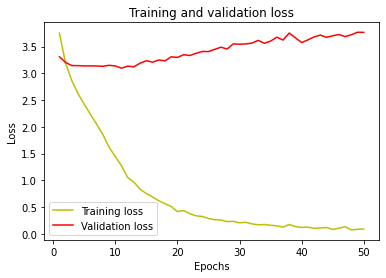

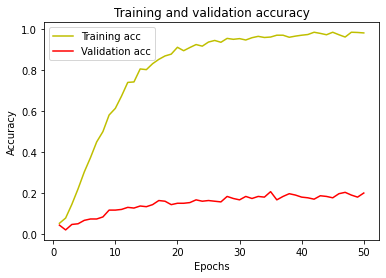

[[2 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 3 2 1 0]
 [1 4 2 0 0 1 2 2 0 0 2 0 0 0 0 2 1 1 0 0]
 [2 0 2 0 1 0 0 0 0 0 0 0 2 0 2 0 3 0 0 0]
 [3 0 3 4 0 1 0 1 1 4 0 0 1 3 0 0 0 1 0 0]
 [1 0 1 0 3 0 1 1 0 1 1 0 0 0 1 1 2 0 0 0]
 [1 0 0 0 2 2 4 0 0 0 2 1 1 2 1 1 0 0 2 0]
 [0 0 1 0 0 1 0 1 1 0 1 0 3 1 1 0 0 0 0 0]
 [1 1 1 2 0 1 2 1 0 0 2 2 1 0 0 0 0 2 0 0]
 [1 0 0 0 2 0 0 2 4 0 3 0 1 1 2 0 0 2 0 0]
 [1 0 1 0 0 1 0 2 1 5 0 0 0 0 0 0 1 0 2 0]
 [0 2 0 1 3 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 1 0 1 1 1 1 2 0 0 0 1 1 0 3 0]
 [0 1 1 0 2 0 1 1 0 3 2 0 2 0 2 0 0 0 0 0]
 [0 1 2 1 0 1 0 3 1 0 2 0 2 3 1 1 4 0 0 0]
 [0 1 0 0 1 0 4 0 0 2 1 0 1 0 2 1 1 1 0 0]
 [1 1 0 1 0 1 2 1 0 0 0 0 3 0 0 3 1 1 0 0]
 [0 1 1 0 0 0 2 0 1 0 1 0 1 2 0 0 6 1 0 0]
 [0 0 1 0 1 0 1 0 2 0 0 1 0 0 0 0 0 6 0 6]
 [0 0 1 0 0 2 2 0 0 0 1 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 4 0 7]]
              precision    recall  f1-score   support

           0       0.13      0.17      0.15        12
           1       0.33      0

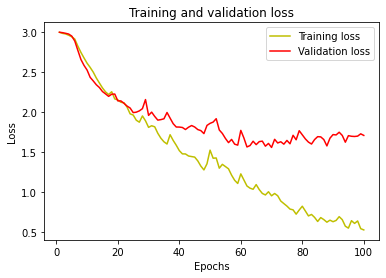

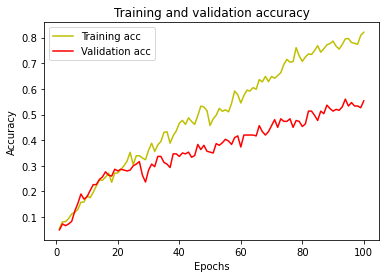

[[ 9  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0]
 [ 3  9  0  0  0  0  0  1  0  0  0  0  0  1  0  2  2  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  6  1  1  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  4  1  0  0  0  0  2  1  0  2  0  0  0  7  0]
 [ 0  1  0  0  0  0  7  0  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0 10  1  0  0  0  0  0  2  3  0  0  0]
 [ 0  1  0  0  0  0  0  1  1  5  0  0  0  0  0  4  2  0  0  0]
 [ 0  0  1  0  2  0  0  0  1  0  3  0  0  0  1  0  2  0  0  0]
 [ 0  0  0  0  0  2  6  0  0  0  1  3  0  0  0  0  0  0  1  1]
 [ 0  0  1  0  3  0  0  0  0  2  2  1  6  0  0  0  0  0  0  0]
 [ 3  0  0  7  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  0  0  0  0 11  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  3  2  0  1  0  0  7  0  0

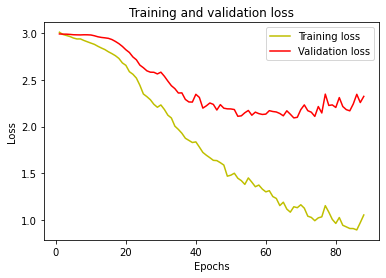

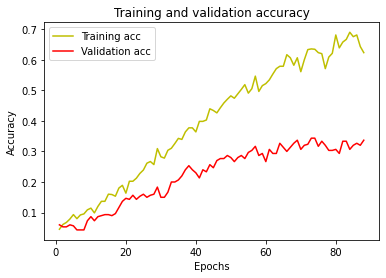

[[ 4  0  0  1  0  0  0  1  1  0  0  0  0  1  0  1  2  1  0  0]
 [ 1  8  0  1  0  0  1  2  1  2  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  2  0  0  1  0  0  0  0  1  0  3  0  3  0  0  0  2  0]
 [ 2  0  0 18  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0]
 [ 0  0  1  0  1  1  1  0  0  1  2  2  2  0  0  0  1  0  0  1]
 [ 0  0  1  0  0  4  0  0  0  0  1  3  1  0  0  0  0  0  9  0]
 [ 0  1  0  0  0  0  4  0  0  0  2  1  0  0  0  2  0  0  0  0]
 [ 3  2  0  3  0  0  0  3  0  0  0  0  0  4  0  0  1  0  0  0]
 [ 2  3  0  1  0  0  1  0  2  3  1  0  0  1  0  0  3  1  0  0]
 [ 0  2  0  0  0  0  2  2  1  1  0  0  0  0  0  1  4  1  0  0]
 [ 0  1  0  0  1  1  0  0  0  2  0  2  0  0  0  0  1  0  2  0]
 [ 0  0  0  0  0  2  1  0  0  0  0  5  0  0  0  1  0  0  5  0]
 [ 0  0  1  0  2  0  1  0  0  0  1  1  2  0  2  0  0  0  3  2]
 [ 4  0  0 10  0  0  0  0  0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  3  0  8  0  0  0  3  0]
 [ 1  0  0  0  4  1  1  1  0  3  1  0  1  0  0  2  0  0

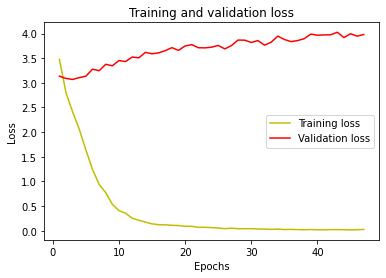

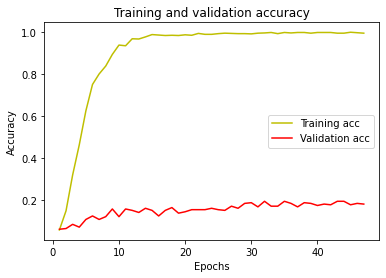

[[ 4  1  0  1  0  0  0  0  0  1  0  0  1  1  0  2  1  0  0  0]
 [ 1  5  1  0  0  2  1  0  0  1  0  1  0  1  1  4  0  0  0  0]
 [ 2  1  2  0  1  0  0  0  0  2  3  0  0  1  0  0  0  0  0  0]
 [ 2  1  0  6  2  1  1  1  1  1  0  1  0  0  0  2  1  0  2  0]
 [ 1  1  0  0  2  0  0  0  0  1  1  2  0  0  1  1  1  1  0  1]
 [ 2  2  0  0  0  0  1  1  1  0  2  2  2  0  1  2  2  0  0  1]
 [ 2  0  0  0  0  0  1  1  0  0  1  0  1  0  3  1  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  3  1  2  0  3  0  0  0  2  1]
 [ 3  1  0  0  0  0  1  0  3  3  1  0  1  2  0  1  1  0  0  1]
 [ 1  1  3  0  1  0  0  0  2  1  1  0  0  0  0  1  1  0  2  0]
 [ 0  3  0  0  1  0  0  0  0  0  1  0  0  1  1  0  3  0  0  0]
 [ 0  1  2  0  2  0  1  0  0  2  1  1  3  0  0  0  0  0  1  0]
 [ 3  1  0  0  0  0  0  0  0  2  0  1  0  1  5  0  0  0  1  1]
 [ 1  0  0  0  2  1  0  1  0  1  5  0  0  1  2  0  7  0  0  1]
 [ 0  1  0  0  1  0  2  0  0  1  1  0  1  0  5  0  2  0  0  1]
 [ 0  4  1  0  0  0  2  0  0  1  2  1  0  2  1  0  0  0

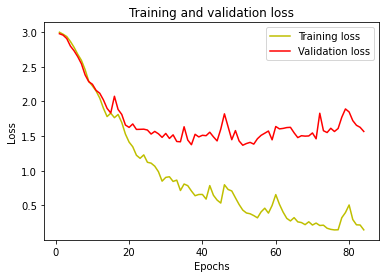

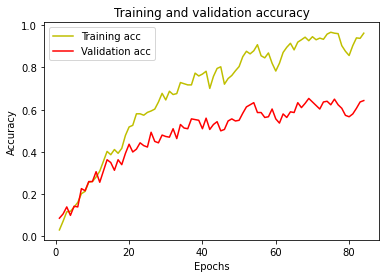

[[ 8  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  2  0  0  0]
 [ 0 10  0  0  1  0  2  1  0  3  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  8  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0 14  0  0  0  1  1  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  1  0  0  0  6  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  0  0  0  3  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  2  0  0  0  1  0  0  0  0]
 [ 0  0  0  2  0  0  0 13  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 3  0  1  0  0  0  1  0  6  2  0  1  0  0  0  0  3  1  0  0]
 [ 0  2  0  0  0  0  1  0  1  6  0  0  0  0  0  1  3  0  0  0]
 [ 0  0  1  0  0  0  0  0  2  0  5  0  1  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  2  1  0  0  0  0 10  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  2  0  1  0  0  0  1  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  1  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  2  3  0  1  0  0  9  0  0

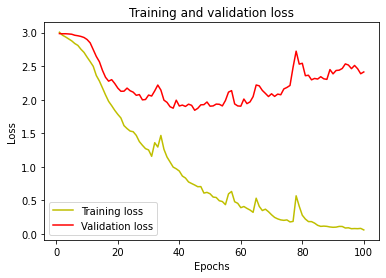

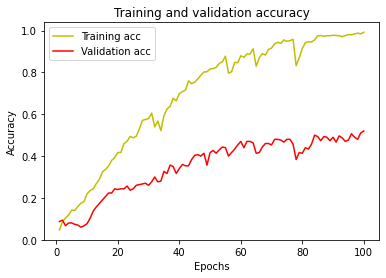

[[ 9  0  0  0  0  0  0  0  2  0  0  0  0  0  0  1  0  0  0  0]
 [ 2 11  0  0  0  0  0  0  1  1  1  0  1  0  0  1  0  0  0  0]
 [ 0  0 10  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0 17  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0  0  6  1  3  0  0  0  1  0  0  0]
 [ 0  0  2  0  0  7  0  0  0  0  0  1  0  0  1  0  0  0  8  0]
 [ 0  0  0  0  1  1  2  0  0  0  1  4  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 13  1  0  0  0  0  1  0  0  0  0  0  0]
 [ 2  2  0  1  0  0  0  0 10  1  0  1  0  0  0  0  1  0  0  0]
 [ 4  2  0  0  0  0  0  0  1  4  0  0  1  0  0  1  1  0  0  0]
 [ 0  0  1  0  3  0  0  0  0  1  2  0  2  0  0  0  1  0  0  0]
 [ 0  0  2  0  2  1  4  0  0  0  0  4  0  0  1  0  0  0  0  0]
 [ 0  0  4  0  4  0  1  0  0  0  5  0  0  0  0  1  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0  7  0  0  0  5  0]
 [ 1  1  1  0  0  0  1  0  0  1  2  0  0  0  0  5  3  0

In [46]:
window_size = 60
cnn_filters = 8
rnn_neurons = 8
kernel = 2
dropout = 0.5
test = f"test2_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)

for i in range(1, 4):
    print("******** " + str(i) + " ********")
    filters = cnn_filters * pow(2,i)
    neurons = rnn_neurons * pow(2,i)
    model = build_model1(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

    model = build_model2(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)
    
    model = build_model3(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)